In [29]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [30]:
from utils import categorical_accuracy, print_scores

In [31]:
import time
import os

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchtext

from gensim.models.keyedvectors import KeyedVectors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, LabelEncoder

import random
import string
import copy

from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
RANDOM_SEED = 123
GLOVE = 1 #Whether to use GloVe vectors or not
GLOVE_DIM = 100
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 0.001
BIDIRECTIONAL = True

torch.manual_seed(RANDOM_SEED)

In [92]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
device

device(type='cuda')

In [93]:
df = pd.read_pickle("./nlp_genre/df_bal_kayla.pkl")
df_test = pd.read_pickle("./nlp_genre/df_test_kayla.pkl")

In [94]:
full_df = pd.concat([df[['lyrics_nsw_alpha_en', 'Genre']], df_test[['lyrics_nsw_alpha_en', 'Genre']]], axis=0).reset_index(drop=True)

In [95]:
full_df.head()

,lyrics_nsw_alpha_en,Genre
0,written baby baby treat bad best boy ever wan ...,Rock
1,saw yesterday shaved body play know fine ca ge...,Rock
2,wan na add subtract put take less back multipl...,Rock
3,well aware happiness get simple struggle survi...,Rock
4,met day feeling usual guess could say sale tak...,Rock


In [96]:
full_df = full_df[~full_df['Genre'].isin(['Indie', 'Folk'])]

In [97]:
full_df.shape

(43837, 2)

In [98]:
le = LabelEncoder()
y = torch.tensor(le.fit_transform(full_df['Genre']))

In [99]:
class Sequences(Dataset):
    def __init__(self, path, y, max_seq_len):
        self.max_seq_len = max_seq_len
        df = path
        self.vectorizer = CountVectorizer(max_features = 20000)# min_df = 0.00001, max_df = 0.8)
        self.vectorizer.fit(df['lyrics_nsw_alpha_en'].tolist())
        self.token2idx = self.vectorizer.vocabulary_
        self.token2idx['<PAD>'] = max(self.token2idx.values()) + 1
        # self.token2idx['<UNK>'] = max(self.token2idx.values()) + 1

        tokenizer = self.vectorizer.build_analyzer()
        self.encode = lambda x: [self.token2idx[token] for token in tokenizer(x)
                                 if token in self.token2idx] # Encode sentences to list of numbers based on token2idx
        self.pad = lambda x: x + (max_seq_len - len(x)) * [self.token2idx['<PAD>']]
        
        sequences = [self.encode(sequence)[:max_seq_len] for sequence in df['lyrics_nsw_alpha_en'].tolist()]
        sequences, self.labels = zip(*[(sequence, label) for sequence, label
                                    in zip(sequences, df['Genre'].tolist()) if sequence])
        self.labels = y
        self.sequences = [self.pad(sequence) for sequence in sequences]

    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)

In [100]:
dataset = Sequences(full_df, y, max_seq_len=150)

In [101]:
len(list(dataset.token2idx.values())) # All values are continuous

20001

In [102]:
if os.path.isfile('./glove'+str(GLOVE_DIM)+'.pth'):
    glove = torch.load('glove'+str(GLOVE_DIM)+'.pth')
else:
    glove = torchtext.vocab.GloVe(name='6B', dim=GLOVE_DIM)
    torch.save(glove, 'glove'+str(GLOVE_DIM)+'.pth')

In [103]:
def get_word(word):
    return glove.vectors[glove.stoi[word]]

In [104]:
get_word('google')

tensor([ 0.2257, -0.5625, -0.0516, -0.0794,  1.1876, -0.4840, -0.2334, -0.8528,
         0.9750, -0.3334,  0.7169,  0.1264,  0.3196, -1.4136, -0.5790, -0.0373,
        -0.0164,  0.4516, -0.2900,  0.5260, -0.2253, -0.2956, -0.0324,  1.5608,
        -0.0135, -0.0646,  0.2663,  0.7860, -0.7169, -0.9302,  0.8046,  1.6035,
        -0.3060, -0.3476,  0.9387,  0.3814, -0.2674, -0.5652,  0.5890, -0.1455,
        -0.3432,  0.2129, -0.3989,  0.0900, -0.8495,  0.3880, -0.5045, -0.2249,
         1.0644, -0.2624,  1.0334,  0.0635, -0.3999,  0.2424, -0.6564, -1.8107,
        -0.0618,  0.1380,  1.1658, -0.3005, -0.5014,  0.1651,  0.0398,  0.6254,
         0.5694,  0.6413,  0.2131,  0.3028,  0.3967,  0.3897,  0.2818,  0.7948,
        -0.1196, -0.4960, -0.5319, -0.1490,  0.5125, -0.3921, -0.5853, -0.0785,
         0.8172, -0.7350, -0.6813,  0.0992, -0.8761,  0.0296,  0.3340, -0.1431,
         0.1696, -0.0352,  0.3978,  0.7177,  0.2587, -0.3620,  0.4570, -0.3916,
        -0.4934, -0.1122,  0.2905,  0.73

In [105]:
matrix_len = len(dataset.token2idx)
weights_matrix = np.zeros((matrix_len, GLOVE_DIM))
words_found = 0

for i, word in enumerate(dataset.token2idx):
    try: 
        weights_matrix[i] = get_word(word)
        words_found += 1
    except KeyError:
        weights_matrix[i] = np.random.normal(scale=0.6, size=(GLOVE_DIM, ))

if torch.cuda.is_available():
    weights_matrix = torch.from_numpy(weights_matrix)

In [106]:
weights_matrix[0]

tensor([-0.5609,  0.2899,  0.0602, -0.1321,  0.7898,  1.0458, -0.1408, -0.4544,
        -0.4954, -0.4279,  0.2538, -0.1159,  0.1499,  0.6569,  0.0729, -0.1770,
         0.4742, -0.0223, -0.5012,  0.4231,  0.1767, -0.3700,  0.0698,  0.1593,
         0.3309, -0.5657, -0.2016, -0.2857, -0.1730,  0.2968,  0.0069,  0.3313,
        -0.1981,  0.0917, -0.3909,  0.4976,  0.0683, -0.1478, -0.4010, -0.1988,
        -0.2229,  0.5856, -0.1999,  0.8001, -0.0515, -0.8825, -0.7649, -0.9991,
        -0.0395, -0.0076,  0.5438,  0.4691,  0.9573,  0.4700, -0.1662, -1.9906,
        -0.2407,  0.0561,  0.9102,  0.2455,  0.4053,  1.1699, -0.5612, -0.6298,
         1.3325, -0.8780,  0.6988,  1.2443,  0.0113, -0.1507, -0.3130,  1.0510,
         0.2988, -0.2263,  0.0576,  0.7482, -0.1628,  0.3070, -1.1076, -0.3732,
        -0.2477, -0.5877, -0.3281, -0.4841, -1.6908,  0.3154,  0.2147, -1.0659,
        -0.3925, -0.1047, -0.2477,  0.0039, -0.4360,  0.1751,  0.3898,  0.4952,
        -0.5688, -0.7036, -0.4410, -0.05

In [107]:
train_split = 0.7
train_size = int(train_split * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [108]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    target = torch.LongTensor([item[1] for item in batch])
    return inputs, target

batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True)#, num_workers = 2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate, shuffle=True)#, num_workers = 2)

In [109]:
class LSTM(nn.Module):
    def __init__(
        self,
        batch_size,
        vocab_size = None,
        weights_matrix = None,
        embedding_dimension=300,
        hidden_size=64, 
        n_layers=1,
        device=device,
        dropout=0.4,
        bidirectional=BIDIRECTIONAL
    ):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.device = device
        self.batch_size = batch_size
        self.bidirectional = bidirectional
        self.directions = 2 if self.bidirectional else 1

        if weights_matrix is not None:
            self.encoder, num_embeddings, embedding_dimension = self.create_emb_layer(weights_matrix, True)
        else:
            self.encoder = nn.Embedding(vocab_size, embedding_dimension)

        self.rnn = nn.LSTM(
            embedding_dimension,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        self.fc = nn.Linear(hidden_size*self.directions, 64)
        self.relu =nn.ReLU()
        self.do = nn.Dropout(p=dropout)
        self.decoder = nn.Linear(64, 6)
        self.sm = nn.Softmax(1)

    def create_emb_layer(self, weights_matrix, non_trainable=False):
        num_embeddings, embedding_dim = weights_matrix.shape
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})

        if non_trainable:
            emb_layer.weight.requires_grad = False

        return emb_layer, num_embeddings, embedding_dim

    def init_hidden(self):
        h0 = torch.randn(self.n_layers*self.directions, self.batch_size, self.hidden_size).to(self.device)
        c0 = torch.randn(self.n_layers*self.directions, self.batch_size, self.hidden_size).to(self.device)
        return (h0, c0)

    def forward(self, inputs):
        # Avoid breaking if the last batch has a different size
        batch_size = inputs.size(0)
        if batch_size != self.batch_size:
            self.batch_size = batch_size

        h0, c0 = self.init_hidden()
        encoded = self.encoder(inputs) # 512x128 -> 512x128x100

        output, (hidden, cell) = self.rnn(encoded, (h0, c0)) #512x128x100 -> 512x128x128
        # output[x, -1, y] is same as hidden
        # output is the collection of hidden states at each time step; hidden is the hidden state at the final time step
        # print(hidden.shape)
        if self.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        else:
            hidden = hidden[-1,:,:].squeeze_(0)
        # print(hidden.shape)
        hidden = self.fc(hidden)
        hidden = self.relu(hidden)
        hidden = self.do(hidden)
        hidden = self.decoder(hidden).squeeze()
        hidden = self.sm(hidden)
        return hidden

In [110]:
if GLOVE:
    model = LSTM(
        hidden_size=200,
        weights_matrix = weights_matrix,
        device=device,
        batch_size=batch_size,
        bidirectional=BIDIRECTIONAL
    )
else:
    model = LSTM(
        hidden_size=256,
        vocab_size=len(dataset.token2idx),
        device=device,
        batch_size=batch_size,
        bidirectional=BIDIRECTIONAL
    )
model = model.to(device)
model

LSTM(
  (encoder): Embedding(20001, 100)
  (rnn): LSTM(100, 200, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=400, out_features=64, bias=True)
  (relu): ReLU()
  (do): Dropout(p=0.4, inplace=False)
  (decoder): Linear(in_features=64, out_features=6, bias=True)
  (sm): Softmax(dim=1)
)

In [111]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [112]:
def train(model, train_loader, confusion=None):
    model.train()
    progress_bar = tqdm_notebook(train_loader, leave=False)
    train_batch_losses = []
    train_batch_accuracy = []
    total = 0

    for inputs, target in progress_bar:
        inputs, target = inputs.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(inputs).to(device)
        # print(output.shape, target.shape)
        loss = criterion(output, target)
        acc = categorical_accuracy(output, target, device)

        loss.backward()

        # nn.utils.clip_grad_norm_(model.parameters(), 3)

        optimizer.step()

        progress_bar.set_description(f'Loss: {loss.item():.3f}')

        train_batch_losses.append(loss.item())
        train_batch_accuracy.append(acc.item())
        total += 1

    if confusion:
        print_scores(target.cpu().clone().detach().numpy(), output.argmax(dim=1, keepdim=True).squeeze().cpu().clone().detach().numpy(), le.classes_)
        # pass

    return train_batch_losses, train_batch_accuracy, total

In [113]:
def evalu(model, test_loader, confusion=None):
    model.eval()
    progress_bar = tqdm_notebook(test_loader, leave=False)
    eval_batch_loss = []
    eval_batch_acc = []
    total = 0

    with torch.no_grad():
        for inputs, target in progress_bar:
            inputs, target = inputs.to(device), target.to(device)
            predictions = model(inputs)

            loss = criterion(predictions, target)

            acc = categorical_accuracy(predictions, target, device)

            eval_batch_loss.append(loss.item())
            eval_batch_acc.append(acc.item())
            total += 1
    if confusion:
        print_scores(target.cpu().clone().detach().numpy(), predictions.argmax(dim=1, keepdim=True).squeeze().cpu().clone().detach().numpy(), le.classes_)
        pass
    return eval_batch_loss, eval_batch_acc, total

/tmp/ipykernel_7441/2542562397.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch #1	Train Loss: 1.706 	Train Accuracy: 0.307
Epoch #1	Eval Loss: 1.636 	Eval Accuracy: 0.391


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch #11	Train Loss: 1.500 	Train Accuracy: 0.536
Epoch #11	Eval Loss: 1.511 	Eval Accuracy: 0.522


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch #21	Train Loss: 1.427 	Train Accuracy: 0.615
Epoch #21	Eval Loss: 1.492 	Eval Accuracy: 0.543


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch #31	Train Loss: 1.350 	Train Accuracy: 0.694
Epoch #31	Eval Loss: 1.479 	Eval Accuracy: 0.561


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch #41	Train Loss: 1.305 	Train Accuracy: 0.740
Epoch #41	Eval Loss: 1.475 	Eval Accuracy: 0.565


  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

/tmp/ipykernel_7441/1687237231.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(test_loader, leave=False)


  0%|          | 0/52 [00:00<?, ?it/s]

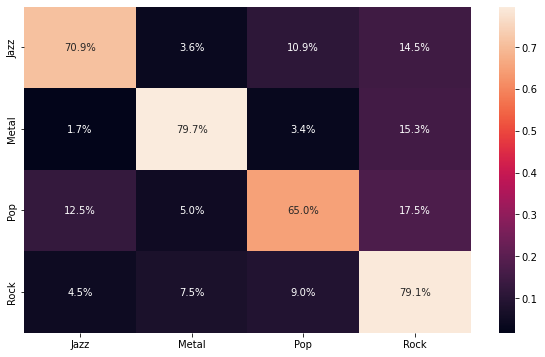

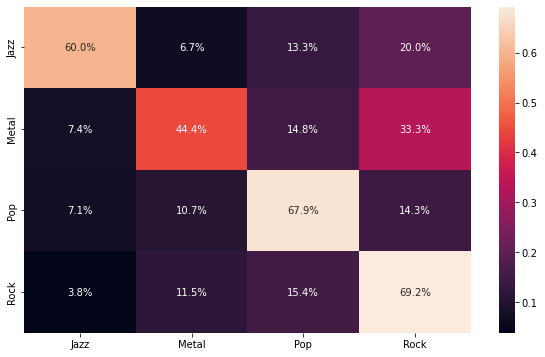

In [114]:
train_losses = []
train_accuracy = []
eval_losses = []
eval_accuracy = []
confusion = False
for epoch in range(EPOCHS):
    if epoch == EPOCHS-1:
        confusion = True
    train_batch_losses, train_batch_accuracy, total = train(model, train_loader, confusion)
    eval_batch_loss, eval_batch_acc, total_ = evalu(model, test_loader, confusion)

    
    train_epoch_loss = sum(train_batch_losses) / total
    train_epoch_acc = sum(train_batch_accuracy) / total
    
    eval_epoch_loss = sum(eval_batch_loss) / total_
    eval_epoch_acc = sum(eval_batch_acc) / total_
    
    train_losses.append(train_epoch_loss)
    train_accuracy.append(train_epoch_acc)
    
    eval_losses.append(eval_epoch_loss)
    eval_accuracy.append(eval_epoch_acc)
    
    if epoch % 10 == 0:
        tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {train_epoch_loss:.3f} \tTrain Accuracy: {train_epoch_acc:.3f}')
        tqdm.write(f'Epoch #{epoch + 1}\tEval Loss: {eval_epoch_loss:.3f} \tEval Accuracy: {eval_epoch_acc:.3f}')

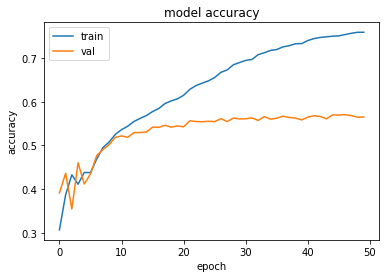

In [115]:
plt.plot(train_accuracy)
plt.plot(eval_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()